<a href="https://colab.research.google.com/github/Pumafi/geostats_deep_learning/blob/main/Corrections/Correction_TP_backpropr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Networks

### Install missing package

In [4]:
!pip install mnist

### Import of external packages

In [5]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import sys 

#### Automatic differentiation

In [7]:
import autograd
import autograd.numpy as np

#### Example

$$f(x) = 2\sqrt{x} + 1$$

$$f'(x) = \frac{1}{\sqrt{x}}$$

In [8]:
def test(x):
    return 2.* np.sqrt(x) + 1.

deriv=autograd.grad(test)
deriv(2.)

0.7071067811865476

### Display functions

In [9]:
def displayFunc(f,xmin=-5.,xmax=5.,by=0.02):
    
    t = np.arange(xmin,xmax,by)
    
    plt.subplot(1, 2, 1)
    plt.plot(t, f.eval(t))
    plt.title(type(f).__name__)
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(t, f.evalderiv(t))
    plt.grid(True)
    plt.title("Derivative of " + type(f).__name__)
    
    plt.show()

In [10]:
def display1D(NN,xmin = -4.,xmax = 4., n = 100):
    discr = np.linspace(xmin,xmax,n)
    output =NN.forward(discr)
    plt.plot(discr,output[0,:])


In [11]:
def displayClassif(NN,xmin=-5.,xmax=5.,n=100,end  = True):
    
    discr = np.linspace(xmin,xmax,n)
    x=np.array([(i, j) for i in discr for j in discr]).T
    output = np.reshape(NN.forward(x),(len(discr),len(discr)))
    classif = (output>0.5).astype(float)

    fig, (ax1,ax2) = plt.subplots(figsize=(13, 4), ncols=2)
    pos = ax1.imshow(output.T,extent=[min(discr), max(discr), min(discr), max(discr)],origin='lower')
    fig.colorbar(pos, ax=ax1)
    ax1.set_title("Neural network output")

    pos = ax2.imshow(classif.T,extent=[min(discr), max(discr), min(discr), max(discr)],origin='lower')
    fig.colorbar(pos)
    ax2.set_title("Classification")
    if end:
        plt.show()
    

In [12]:
def view_classify(img, ps):
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.reshape(1, 28, 28).squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

### Abstract class for activation functions

In [13]:
class Activation():
    def __init__(self):
        self.deriv = autograd.elementwise_grad(self.eval)
        pass

    def eval(self,x):
        pass
    
    def evalderiv(self,x):
        return self.deriv(x)
        

#### Example : the identity function

$$f(x) = x$$

$$f'(x) = 1$$

1) If you don't want to specify the derivative, make inherit from Activation

In [14]:
class identityLazy(Activation):
    
    def eval(self,x):
        return x

2) If you agree to specify the derivative, it is useless (and possibly more time consuming) to make inherit from Activation

In [15]:
class identity():
    
    def eval(self,x):
        return x
    
    def evalderiv(self,x):
        return np.ones_like(x)

In [16]:
uLazy = identityLazy()
uLazy.evalderiv(4.)

array(1.)

In [17]:
u = identity()
u.evalderiv(4.)

array(1.)

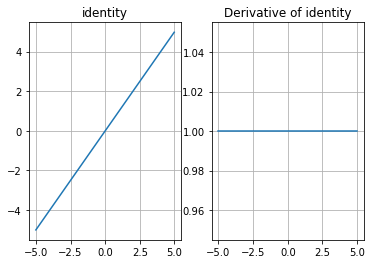

In [18]:
displayFunc(u)

### Other usual activation functions

#### Sigmoid (a.k.a logistic function)

$$f(x) = \frac{1}{1+e^{-x}}$$

$$f'(x) = f(x)  (1-f(x))$$

In [19]:
class sigmoid():
     def eval(self,x):
        return 1./(1.+np.exp(-x))
    
     def evalderiv(self,x):
        p = self.eval(x)
        return p * (1-p)

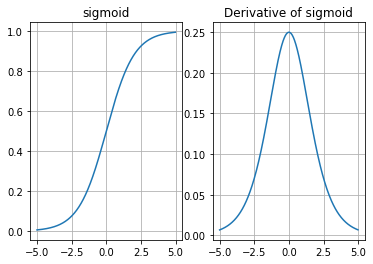

In [20]:
displayFunc(sigmoid())

#### SoftMax (for multi-label classification)

It is the inverse transformation of the centered log-ratio


$$f(x_1,\dots,x_K)=\frac{1}{\sum_{k=1}^K e^{x_k}}\left(\begin{array}{c} e^{x_1} \\ \vdots \\ e^{x_K}\end{array}\right)$$

If SoftMax is used for binary classification, it corresponds to the sigmoid function up to a reparametrization.

http://web.stanford.edu/~nanbhas//blog/sigmoid-softmax.html

#### Hyperbolic tangent

$$f(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$$

$$f'(x) = 1 - f^2(x)$$

In [21]:
class hyperbolicTangent():
     def eval(self,x):
        return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
    
     def evalderiv(self,x):
        return  1 - self.eval(x)**2    

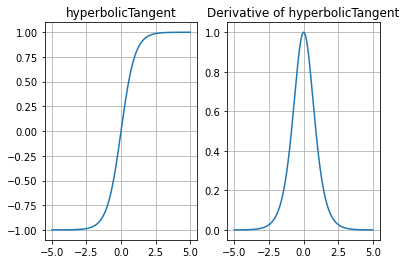

In [22]:
displayFunc(hyperbolicTangent())

#### ReLU (Rectified Linear Unit)

$$f(x) = \max(0,x) = x \mathbb{1}_{]0,+\infty[}(x)$$

$$f'(x) = \mathbb{1}_{]0,+\infty[}(x)$$

In [23]:
class ReLU():
     def eval(self,x):
        return x * self.evalderiv(x)  #Beware of not make inherit ReLu from Activation
    
     def evalderiv(self,x):
        return  (x >= 0).astype(float)     

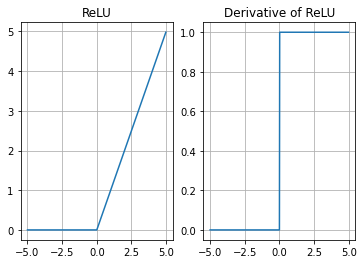

In [24]:
displayFunc(ReLU())

#### Leaky ReLU

$$f(x) = \max(\varepsilon x,x)$$

$$f'(x) = \varepsilon\mathbb{1}_{]-\infty,0[}(x) + \mathbb{1}_{]0,+\infty[}(x)$$

In [25]:
class LeakyReLU():
     def __init__(self,eps):
            self.eps = eps
            
     def eval(self,x):
        return x * self.evalderiv(x)   #Beware of not make inherit LeakyReLu from Activation
    
     def evalderiv(self,x):
        indic = (x >= 0).astype(float)     
        return  self.eps * (1. - indic) + indic

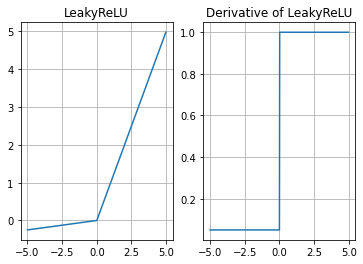

In [26]:
displayFunc(LeakyReLU(0.05))

## I. First implementation of the MultiLayer Perceptron class

### Build a layer

In the following code, you build the class for a layer.
A layer is specified by the dimension of the input (Ninput), the one of the ouput (Noutput), and an activation function (an object with a method "eval")
The function forward compute the output of a given layer from the input vector. Note that the input vector does not include the constant 1 for the bias term.

In [27]:
#Q1
class DenseLayer:
    
    def __init__(self,Ninput=1,Noutput=1,Activation = identity(),seed = None,L=1):
        self.Activation = Activation
        self.Weights = None
        self.setRandomWeights(seed,L,Ninput,Noutput)
        
        #Stored object
        self.tildeV = None
        self.S = None
        self.grad = None
        
    def setRandomWeights(self , seed = None , L = 1,Ninput = None,Noutput = None):
        " Create and Fill the weights matrix with random uniform number on [-L,L]"
        " If specified, the seed of the numpy random number generator will be set to seed"
        
        if seed is not None:
            np.random.seed( seed )
           
        if Ninput is None:
            self.Weights =  L * (np.random.rand( self.Weights.shape[0], self.Weights.shape[1])-0.5) 
        else:      
        #Your code (fill the None)
            self.Weights =  L * (np.random.rand( Noutput, Ninput + 1)-0.5) 
        #END
    def forward(self,V):
        "This function take as entry a matrix (array) of size Ninput x N"
        "It returns the evaluation of the layer"
        V = np.atleast_2d(V) #See Glossary at the end of the notebook
        ones = np.ones(np.shape(V)[1])
    #Your code (fill the None)
        self.tildeV = np.row_stack( ( ones , V) )
        self.S = self.Weights @ self.tildeV
        result = self.Activation.eval(self.S)
    #END
        return result

#### Test

After running the next chunk, "Success" has to be displayed. Otherwise, something is wrong

In [28]:
#Do not edit

A = DenseLayer(2,1,sigmoid(),seed=24)

x=np.random.rand(2,10)
#Evaluate Layer 1
res = A.forward(x)
assert np.all(abs(res - [0.72189383 ,0.68976893, 0.67507701, 0.73000272, 0.69081288, 0.68102093,
  0.72774888, 0.72015744 ,0.66509593, 0.71445135])< 1e-5)
ndata = 2
x=np.random.rand(1,2)
A = DenseLayer(1,1,sigmoid(),seed=24)
res = A.forward(x)
assert np.all(abs(res - [0.64467951, 0.65782785])< 1e-5)
print("Success")

Success


In [29]:
ninput = 2
noutput = 1
ndata = 10
print("Weights :\n ",A.Weights)

Weights :
  [[0.4600173  0.19951205]]


In [30]:
class MultiLayerPerceptron :
    
    def __init__(self):
        self.Layers = []

    def initWeights(self,seed = None,L=1):
        if seed is not None:
            np.random.seed(seed)
        for l in self.Layers:
            l.setRandomWeights(seed ,L)
            
    def add(self,layer):
        self.Layers = self.Layers + [layer]

    def forward(self , x):
        for l in self.Layers:
            x = l.forward(x)
        return x
    
    

### Linear Regression (1D)

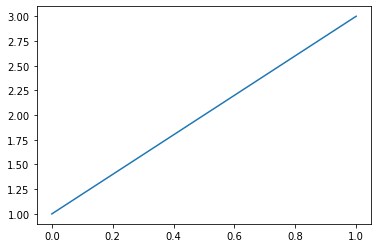

In [31]:
NN = MultiLayerPerceptron()
A1 = DenseLayer(1,1,identity(),seed=9)
A1.Weights[0][0]=1.
A1.Weights[0][1]=2.
NN.add(A1)
display1D(NN,0,1)

### Non-linear Regression (1D)

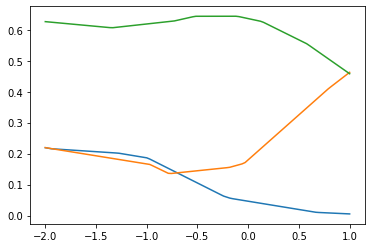

In [32]:
NN = MultiLayerPerceptron()
A1 = DenseLayer(1,12,ReLU(),seed=3)
NN.add(A1)
A2 = DenseLayer(12,1,identity())
NN.add(A2)
display1D(NN,-2,1)
NN.initWeights(23)
display1D(NN,-2,1)
NN.initWeights(24)
display1D(NN,-2,1)

### Logistic Regression (2D)

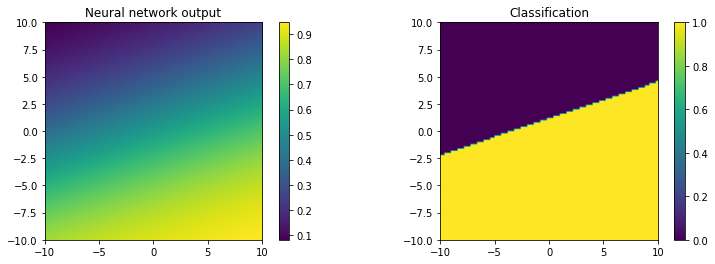

In [33]:
NN = MultiLayerPerceptron()
A1 = DenseLayer(2,1,sigmoid(),seed=98)
NN.add(A1)
displayClassif(NN,-10,10)

### Binary classification (2D)

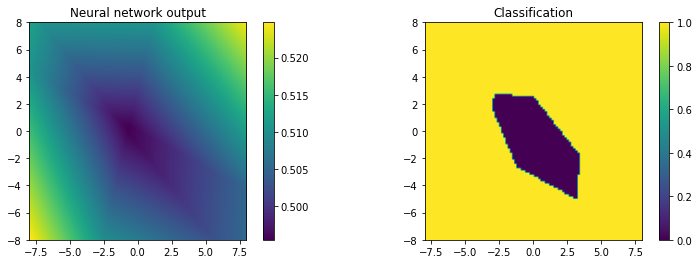

In [34]:
Nhidden = 3
NN = MultiLayerPerceptron()

A1 = DenseLayer(2,Nhidden,ReLU(),seed=8,L=0.3)
A1.Weights
NN.add(A1)
A2 = DenseLayer(Nhidden,1,sigmoid())
NN.add(A2)
x=np.random.rand(ninput,ndata)
NN.forward(x)
displayClassif(NN,-8,8)

## II. Evaluate a neural network

In [35]:
class Cost():
    def __init__(self):
        self.deriv = autograd.elementwise_grad(self.funct)
        pass

    def funct(self,predict,real):
        pass
    
    def eval(self,predict,real):
        return np.sum(self.funct(predict,real))
    
    def evalderiv(self,predict,real):
        return self.deriv(predict,real)

### Cost functions

The cost function between the true value $y^{(t)}$ and the predicted value (or predicted probability for classification) $f_\omega(x)$ is given by $$L(y^{(t)},y^{(p)})=\frac{1}{n}\sum_{i=1}^n l(y_i^{(t)},y_i^{(p)})$$


#### Mean Squared Error

This function is used for regression where the output vector $y^{(p)}$ is generally the linear term of the last layer (identity activation):

$$l(y^{(p)},y^{(t)}) = \frac{1}{2}(y_i^{(p)}-y_i^{(t)})^2$$

#### Gradient


$$\frac{\partial L}{\partial y_i^{(p)}}= y_i^{(p)}-y_i^{(t)}$$ 


In [36]:
class MeanSquare():
    def eval(self,predict,real):
        return 0.5 * np.sum((predict-real)**2)
    
    def evalderiv(self,predict,real):
        return predict - real


#### Binary Cross-Entropy

This function is used for classification where the ouput vector $y^{(p)}$ is computed from the sigmoid function applied to the linear term of the last layer :

$$y^{(p)}_i = \frac{1}{1+e^{-s_i}}$$ 

$$L(y^{(p)},y^{(t)}) = -\sum_{i=1}^n \left(y_i^{(t)}\log(y_i^{(p)}) + (1-y_i^{(t)})\log(1-y_i^{(p)})\right)$$

#### Gradient

$$\frac{\partial L}{\partial y_i^{(p)}}= -\frac{y_i^{(t)}}{y_i^{(p)}}+\frac{1-y_i^{(t)}}{1-y_i^{(p)}}=\frac{y_i^{(p)}-y_i^{(t)}}{y_i^{(p)}  (1-y_i^{(p)})}$$ 

$$\frac{\partial L}{\partial s_i} = \frac{\partial L}{\partial y_i^{(p)}}\frac{\partial y_i^{(p)}}{\partial s_i} = 
y_i^{(p)}-y_i^{(t)}$$

In [37]:
class BinaryCrossEntropy():
    def eval(self,predict,real):
        return - np.sum( real * np.log(predict) + (1-real)*np.log(1-predict) )
    
    def evalderiv(self,predict,real):
        return (predict - real)/(predict*(1-predict))

### Remark:

For multi-label classification, the cost-function is generally the cross entropy:


$$L(y^{(p)},y^{(t)}) =-\sum_{i=1}^n \sum_{k=1}^K \left({y_k}_i^{(t)}\log({y_k}_i^{(p)})\right)$$

where $y_k^{(p)}$ is the predicted probability vector for the class $k$ and $y_k^{(t)}$ is the indicator vector of the class $k$.

Used with the softmax activation function for the output layer, similar simplifications occur.

## III. Learn a neural network

### Gradient of the cost function with respect to the weights

### 1) Back-propagation

In [38]:
def BackPropGeneric(NN,x,real,cost):
    predict = NN.forward(x)
    l = NN.Layers[len(NN.Layers)-1]        
    E = cost.evalderiv(predict,real).T * l.Activation.evalderiv(l.linear).T
    for il in reversed(range(len(NN.Layers))):     
        l.grad = E.T @ l.tildeV.T
        if il>0:
            E = (E @ l.Weights[:,1:])
            l = NN.Layers[il-1]
            E = E * l.Activation.evalderiv(l.S).T

            
def BackProp(NN,x,real,cost):
    predict = NN.forward(x)
    E = (predict - real).T
    for il in reversed(range(len(NN.Layers))):
        l = NN.Layers[il]        
        l.grad = E.T @ l.tildeV.T
        if il>0:
            lp = NN.Layers[il-1]
            E = (E @ l.Weights[:,1:]) * lp.Activation.evalderiv(lp.S).T

###  2) Finite differences

In [39]:
def FinDiff(NN,x,real,cost = MeanSquare,delta=1e-6):

    res = [ np.zeros( np.shape(l.Weights) )  for l in NN.Layers  ]

    for s,l in enumerate(NN.Layers):
        for j in range(l.Weights.shape[0]):
            for k in range(l.Weights.shape[1]):
    
                W = l.Weights
                W[j,k] = W[j,k] + delta
                predict1 = NN.forward(x)
            
                W[j,k] = W[j,k] - 2 * delta
                predict2 = NN.forward(x)
                res[s][j,k] = (cost.eval(predict1 , real )- cost.eval(predict2 , real ))/(2*delta)
                W[j,k] = W[j,k] + delta
    return res

    

        

### Comparison of the two approaches

In [40]:
def testNN(ninput = 3,nhidden1 = 6,nhidden2 = 5,noutput = 1,ndata= 20,cost=MeanSquare,last = identity):

    x=np.random.rand(ninput,ndata)

    NNr = MultiLayerPerceptron()
    A1r = DenseLayer(ninput,nhidden1,sigmoid(),seed=4)
    NNr.add(A1r)
    A2r = DenseLayer(nhidden1,nhidden2,sigmoid())
    NNr.add(A2r)
    A3r = DenseLayer(nhidden2,noutput,last())
    NNr.add(A3r)
    real = NNr.forward(x)

    
    NNr.initWeights()
    predict = NNr.forward(x)

    resb = FinDiff(NNr,x,real,cost())
    Gradientb=BackProp(NNr,x,real,cost())

    nl=len(NNr.Layers)
    for i in range(nl):
        plt.subplot(1,nl,i+1)
        u=resb[i]
        plt.scatter(resb[i],NNr.Layers[i].grad)
        plt.plot((np.min(u),np.max(u)),(np.min(u),np.max(u)),c='r')




##### Test in the regression case

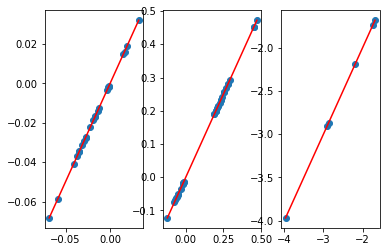

In [41]:
testNN(cost=MeanSquare,last = identity)

##### Test in the classification case

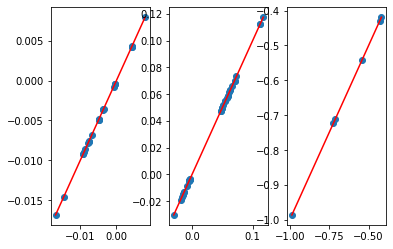

In [42]:
testNN(cost=BinaryCrossEntropy,last =sigmoid)

### Neural network to approach a Gaussian random field realization

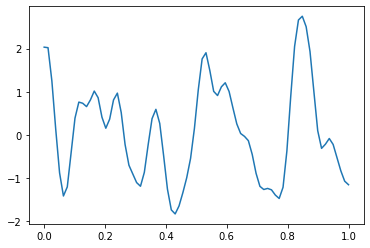

In [43]:
x = np.linspace(0,1,80)
w=np.random.normal(0,1,size=len(x))
sigma = np.exp(-(np.abs(x[:, None] - x)/0.04)**2)
real = np.linalg.cholesky(sigma) @ w
plt.plot(x,real)


891970.9727519528
3.892924570018114


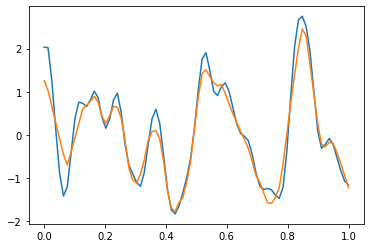

In [44]:
plt.plot(x,real)
Nhidden = 1000
NN = MultiLayerPerceptron()
A1 = DenseLayer(1,Nhidden,ReLU(),seed=14,L=10)
NN.add(A1)
A2 = DenseLayer(Nhidden,1,identity(),L=10)
NN.add(A2)

predict = NN.forward(x)
print(MeanSquare().eval(predict,real))
#plt.plot(x,predict[0,:])

for epoch in range(200):
    indices = np.random.choice(range(x.shape[0]),x.shape[0],replace=False)
    for i in range(80):
        ind = indices[np.arange(1)+i*1]
        BackProp(NN,x[ind],real[ind],MeanSquare())
        for l in NN.Layers:
            l.Weights = l.Weights -0.01/len(x) * l.grad
    

predict = NN.forward(x)
print(MeanSquare().eval(predict,real))
plt.plot(x,predict[0,:])


### 2D classification

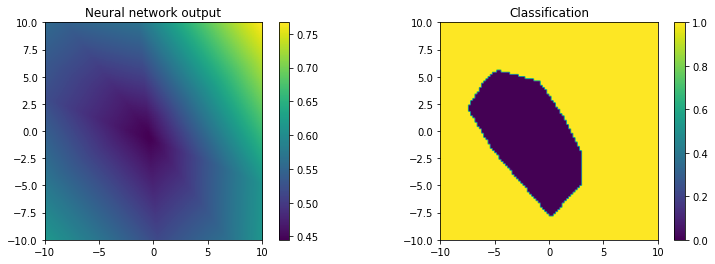

In [45]:
NN = MultiLayerPerceptron()
Hidden = 5
A1 = DenseLayer(2,Hidden,ReLU(),seed=24,L=.5)
NN.add(A1)
A2 = DenseLayer(Hidden,1,sigmoid())
NN.add(A2)
displayClassif(NN,-10,10)


In [46]:
ndata = 200
x_train=-8 + 16 * np.random.uniform(0,1,(2,ndata))
real = NN.forward(x_train)
real = (real>0.5).astype(float)

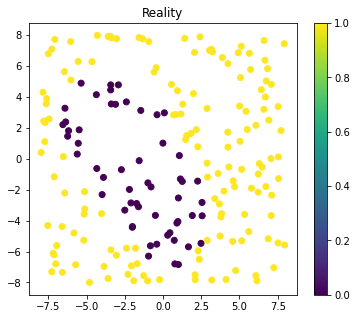

In [47]:
fig, ax1 = plt.subplots(figsize=(6, 5), ncols=1)
pos = ax1.scatter(x_train[0,:],x_train[1,:],c=real)
fig.colorbar(pos, ax=ax1)
ax1.set_title("Reality")
plt.show()

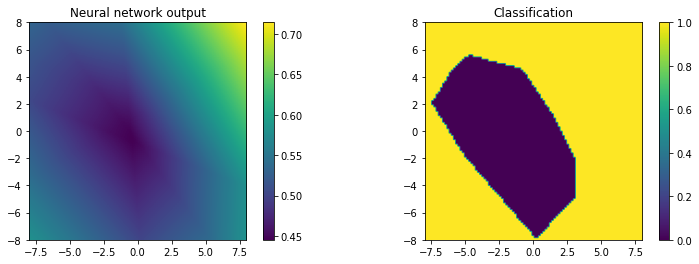

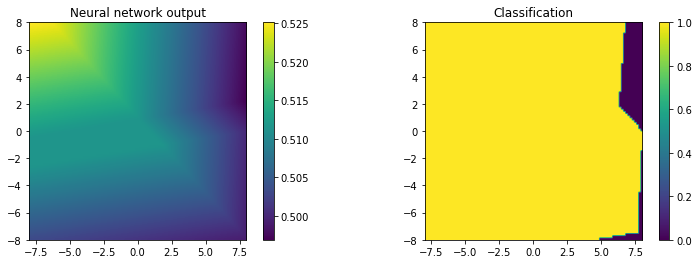

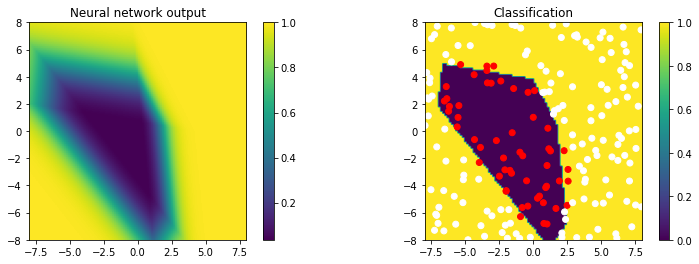

In [48]:
displayClassif(NN,-8,8)
Nhidden = 3
NNfit = MultiLayerPerceptron()
A1 = DenseLayer(2,Nhidden,ReLU())
NNfit.add(A1)
A2 = DenseLayer(Nhidden,1,sigmoid(),L=0.1)
NNfit.add(A2)
displayClassif(NNfit,-8,8)

for epoch in range(10000):
    BackProp(NNfit,x_train,real,BinaryCrossEntropy())
    for l in NNfit.Layers:
        l.Weights = l.Weights -0.01/x_train.shape[1] * l.grad
    
displayClassif(NNfit,-8,8,end=False)
plt.scatter(x_train[0,:],x_train[1,:],c=[['r','w'][i] for i in real[0].astype(int)])
plt.show()

### Representation of the hidden layer output and the last separating plane

In [49]:
outputA1 = A1.forward(x_train)
output = NNfit.forward(x_train)
classif =(output>0.5).astype(int)

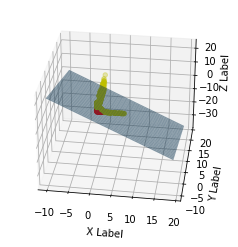

In [50]:
from mpl_toolkits.mplot3d import Axes3D


#%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')



xs = outputA1[0,:]
ys = outputA1[1,:]
zs = outputA1[2,:]
ax.scatter(xs, ys, zs.astype(float), c=[['r','y'][i]  for i in classif[0]],zdir='y')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')


Weights = NNfit.Layers[1].Weights[0]

xx, yy = np.meshgrid(range(-10,20), range(-10,20))
z = (-Weights[0]- Weights[1]*xx - Weights[2]*yy) /Weights[3]

# plot the plane
ax.plot_surface(xx, yy, z, alpha=0.5)
ax.view_init(30, -82)
plt.show()



### To play 

https://playground.tensorflow.org/

In [67]:
class SGD():
    
    def __init__(self,NN,learning_rate):
        self.NN=NN
        self.lr = learning_rate
    
    def update(self):
        for l in self.NN.Layers:
            l.Weights -= self.lr * l.grad
            
class Adam():
    
    def __init__(self,NN,learning_rate,beta1=0.9,beta2=0.999,eps = 0.0001):
        self.NN=NN
        self.lr = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = 0.00001
        self.momentum = []
        self.v = []
        self.it = 0
        for l in self.NN.Layers:
            self.momentum +=[np.zeros_like(l.Weights)]
            self.v +=[np.zeros_like(l.Weights)]
            
    def update(self):
        self.it += 1
        for il,l in enumerate(self.NN.Layers):
            self.momentum[il]=self.beta1 * self.momentum[il]+(1-self.beta1)*l.grad
            self.v[il]=self.beta2 * self.v[il] +(1-self.beta2)*l.grad**2
            hatm = self.momentum[il]/(1-self.beta1**self.it)
            hatv = self.v[il] /(1-self.beta2**self.it)
            l.Weights -= self.lr * hatm/(np.sqrt(hatv)+self.eps)
            
    

### Load and display the data

In [68]:
import mnist
%matplotlib inline
images_train = np.array(mnist.train_images())
images_test = np.array(mnist.test_images())

digits_train = mnist.train_labels()
digits_test = mnist.test_labels()

print("shape of the data set ",images_train.shape)

shape of the data set  (60000, 28, 28)


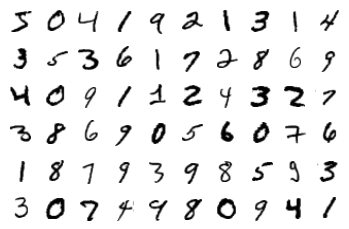

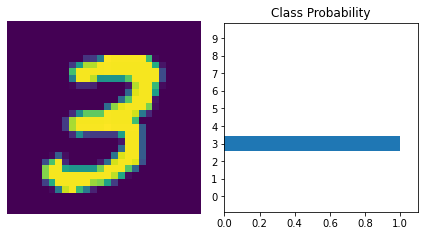

In [69]:
figure = plt.figure()
num_of_images = 60
for index in range(num_of_images):
    plt.subplot(6, 10, index+1)
    plt.axis('off')
    plt.imshow(images_train[index], cmap='gray_r')

index = 7
view_classify(images_train[index,:],np.identity(10)[digits_train[index],:])

### Transformations of the data

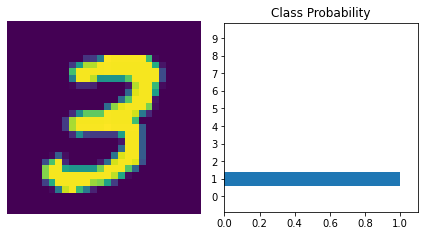

In [70]:

x_train = images_train/255
x_test = images_test/255

Ninput = 28 *28
x_train = x_train.reshape([x_train.shape[0],Ninput]).T
x_test = x_test.reshape([x_test.shape[0],Ninput]).T



#Transform label to indicator (multi-class problem becomes binary class)

digit = 3

label_train = copy.copy(digits_train)
label_test = copy.copy(digits_test)

label_train[label_train!=digit]=10
label_train[label_train==digit]=1
label_train[label_train==10]=0

label_test[label_test!=digit]=10
label_test[label_test==digit]=1
label_test[label_test==10]=0


view_classify(images_train[index,:],np.identity(10)[label_train[index],:])


In [71]:
def evaluateNN(NN,x,real,cost):
    predict=NN.forward(x)
    indic = predict[0,:]>0.5
    ind    = [i for i, x in enumerate(indic) if x]
    indneg = [i for i, x in enumerate(indic) if not x]
    sensitivity = sum(real[ind]==1)/sum(real)
    specificity = sum(real[indneg]==0)/sum(1-real)
    costVal = cost.eval(predict,real)/x.shape[1]
    return costVal, sensitivity,specificity

In [72]:
class displayResults():
    def __init__(self,NN,x_train,x_test,label_test,label_train,cost,display_step=10):
        self.N=1
        self.str = " "
        self.cost = cost
        self.display_step = display_step
        self.NN = NN
        self.label_test=label_test
        self.label_train = label_train
        self.x_test = x_test
        self.x_train = x_train
    def display(self,epoch):
        if epoch%self.display_step == 0 :
            if epoch % self.N ==0:
                self.str += " "
                self.N *=10
            costTrain,sensitTrain,specTrain = evaluateNN(self.NN,self.x_train,self.label_train,self.cost)
            costTest ,sensitTest ,specTest  = evaluateNN(self.NN,self.x_test ,self.label_test ,self.cost)
            print("Epoch {} - Training: Cost {:.4f} - Sensit: {:.4f} - Specic :{:.4f}".format(epoch,costTrain,sensitTrain,specTrain))
            print(self.str + "        Test:     Cost {:.4f} - Sensit: {:.4f} - Specic :{:.4f}".format(costTest,sensitTest,specTest))
        
        

### Creation of the neural network

In [73]:
Nhidden = 10
NN = MultiLayerPerceptron()
A1 = DenseLayer(Ninput,Nhidden,ReLU(),seed=333,L=0.5)
NN.add(A1)
A2 = DenseLayer(Nhidden,1,sigmoid(),L=0.5)
NN.add(A2)

### Display initial weights

bias first layer [ 0.11  0.25 -0.25  0.24 -0.18  0.03  0.14  0.21 -0.16  0.07]
weights second layer [[ 0.05 -0.01  0.09  0.11  0.03 -0.23 -0.17 -0.06  0.25  0.04]]


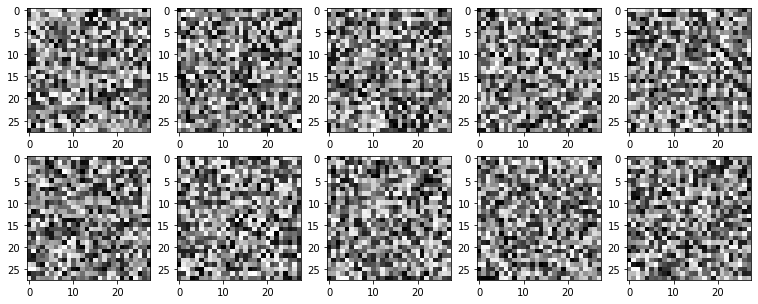

In [74]:
nrd = 2
ncd = 5
u=NN.Layers[0].Weights[:,1:]
print("bias first layer",np.round(u[:,0],2))
plt.subplots(figsize=(13, 5), ncols=2)
for i in range(u.shape[0]):
    plt.subplot(nrd,ncd,i+1)
    plt.imshow(np.reshape(u[i,:],(28,28)), cmap='gray_r')
print("weights second layer",np.round(NN.Layers[1].Weights[:,1:],2))

### Algorithm parameters

In [75]:
cost = BinaryCrossEntropy()

#optimizer = SGD(NN,0.00001)

optimizer = Adam(NN,0.0005)

#Batch handling

batch_size = 10
n_batch = x_train.shape[1]//batch_size

# Number of epochs 

n_epochs = 20

#Display class (observer)

display_step = 1
displ = displayResults(NN,x_train,x_test,label_test,label_train,cost,display_step)

### Training loop

In [76]:
for epoch in range(n_epochs):
    
    #Monitor results
    
    displ.display(epoch)

    #Shuffle the indices
    indices = np.random.choice(range(x_train.shape[1]),x_train.shape[1],replace=False)
    for i in range(n_batch):
        ind = indices[np.arange(batch_size)+i*batch_size]
        BackProp(NN,x_train[:,ind],label_train[ind],cost)
        optimizer.update()

print("End of training")       

Epoch 0 - Training: Cost 0.6955 - Sensit: 0.5415 - Specic :0.5289
          Test:     Cost 0.6938 - Sensit: 0.5347 - Specic :0.5367
Epoch 1 - Training: Cost 0.0753 - Sensit: 0.8191 - Specic :0.9952
          Test:     Cost 0.0680 - Sensit: 0.8376 - Specic :0.9958
Epoch 2 - Training: Cost 0.0554 - Sensit: 0.9023 - Specic :0.9925
          Test:     Cost 0.0521 - Sensit: 0.9158 - Specic :0.9918
Epoch 3 - Training: Cost 0.0416 - Sensit: 0.9059 - Specic :0.9961
          Test:     Cost 0.0396 - Sensit: 0.9089 - Specic :0.9963
Epoch 4 - Training: Cost 0.0332 - Sensit: 0.9323 - Specic :0.9960
          Test:     Cost 0.0318 - Sensit: 0.9376 - Specic :0.9961
Epoch 5 - Training: Cost 0.0281 - Sensit: 0.9388 - Specic :0.9969
          Test:     Cost 0.0273 - Sensit: 0.9485 - Specic :0.9969
Epoch 6 - Training: Cost 0.0250 - Sensit: 0.9537 - Specic :0.9963
          Test:     Cost 0.0252 - Sensit: 0.9614 - Specic :0.9960
Epoch 7 - Training: Cost 0.0220 - Sensit: 0.9527 - Specic :0.9977
          

/home/ndesassis/python3/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
/tmp/ipykernel_22013/2442775786.py:3: RuntimeWarning: invalid value encountered in multiply
  return - np.sum( real * np.log(predict) + (1-real)*np.log(1-predict) )


Epoch 19 - Training: Cost nan - Sensit: 0.9850 - Specic :0.9984
           Test:     Cost nan - Sensit: 0.9634 - Specic :0.9950
End of training


### Prediction value for the false negative

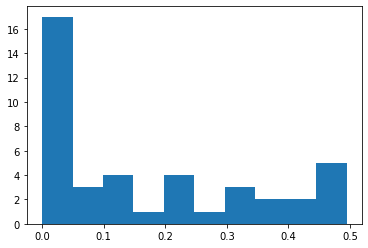

In [77]:
x = x_test
real = label_test
digits = digits_test
predict=NN.forward(x)[0,:]
negative = predict<0.5
indicpos =  real==1
plt.hist(predict[negative&indicpos])
plt.show()

3

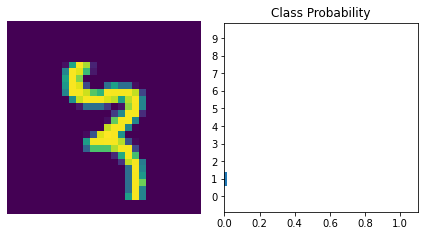

In [78]:
strongly_negative = predict<0.05
ind = 3
num = [i for i,u in enumerate(strongly_negative & indicpos) if u][ind]
view_classify(x[:,num],predict[num]*np.identity(10)[real[num],:])
digits[num]

### Prediction value for the false positive

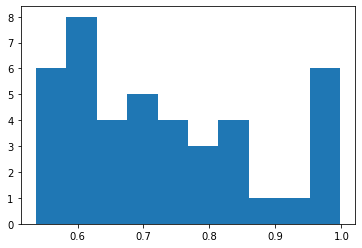

In [79]:
positive = predict>0.5
indic =  real ==0
plt.hist(predict[positive&indic])
plt.show()

8

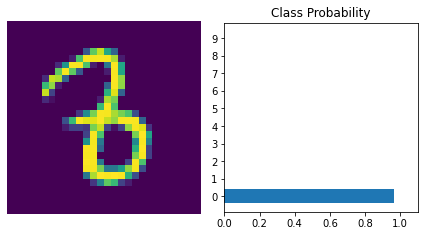

In [80]:
strongly_positive = predict>0.9
ind = 1
num = [i for i,u in enumerate(strongly_positive & indic) if u][ind]
view_classify(x[:,num],predict[num]*np.identity(10)[real[num],:])
digits[num]

### Display weights after training

bias first layer [ 0.11  0.25 -0.25  0.24 -0.18  0.03  0.14  0.21 -0.16  0.07]
weights second layer [[ 1.   -0.81  1.27  1.71  0.85 -0.91 -1.55 -0.68  1.29 -1.09]]


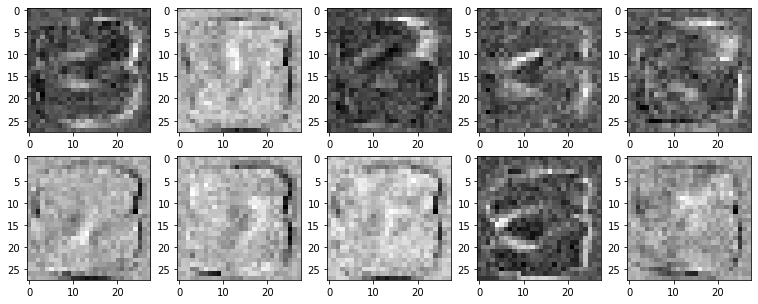

In [81]:
u=NN.Layers[0].Weights[:,1:]
print("bias first layer",np.round(u[:,0],2))

plt.subplots(figsize=(13, 5), ncols=2)
for i in range(u.shape[0]):
    plt.subplot(nrd,ncd,i+1)
    plt.imshow(np.reshape(u[i,:],(28,28)), cmap='gray_r')

print("weights second layer",np.round(NN.Layers[1].Weights[:,1:],2))

### Glossary

numpy.atleast_2d

In [82]:
x= np.array([3,1])
print(x)
print(x.shape)
y = np.atleast_2d(x)
print(y)
print(y.shape)

[3 1]
(2,)
[[3 1]]
(1, 2)


### Miscellaneous

Regression problem with ADAM

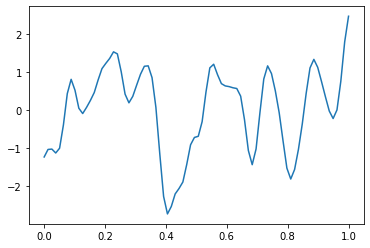

In [83]:
x = np.linspace(0,1,80)
w=np.random.normal(0,1,size=len(x))
sigma = np.exp(-(np.abs(x[:, None] - x)/0.04)**2)
real = np.linalg.cholesky(sigma) @ w
plt.plot(x,real)

892229.4798854375
End of training
2.1936294875695235


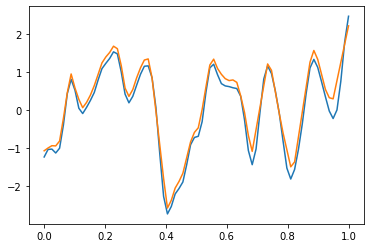

In [84]:
plt.plot(x,real)
Nhidden = 1000
NN = MultiLayerPerceptron()
A1 = DenseLayer(1,Nhidden,ReLU(),seed=14,L=10)
NN.add(A1)
A2 = DenseLayer(Nhidden,1,identity(),L=10)
NN.add(A2)


predict = NN.forward(x)
print(MeanSquare().eval(predict,real))
#plt.plot(x,predict[0,:])

    

cost = MeanSquare()

optimizer = Adam(NN,0.0001)

batch_size = 1
n_batch = x.shape[0]//batch_size


for epoch in range(1000):
   
    #Shuffle the indices
    indices = np.random.choice(range(x.shape[0]),x.shape[0],replace=False)
    for i in range(n_batch):
        ind = indices[np.arange(batch_size)+i*batch_size]
        BackProp(NN,x[ind],real[ind],cost)
        optimizer.update()

print("End of training")       




predict = NN.forward(x)
print(MeanSquare().eval(predict,real))
plt.plot(x,predict[0,:])